<a href="https://colab.research.google.com/github/matiasvallejosdev/ar-dl-color-mapping/blob/main/Project.DeepLearning/cm_imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras as tk
import tensorflow.keras.preprocessing.image as tfi
import numpy as np
import pandas as pd

import pathlib
import imageio
import random

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

tf.__version__

'2.7.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = ("/content/drive/My Drive/Machine Learning/Datasets/cat-vs-dog/")

In [ ]:
os.chdir(DATA_DIR)
os.listdir()

['train', 'test']

## Load data

In [ ]:
EPOCHS = 5
BATCH_SIZE = 12

IMAGE_WIDHT = 128
IMAGE_HEIGHT = 128
IMAGE_SHAPE = (IMAGE_WIDHT, IMAGE_HEIGHT) # (height, width) in no. of pixels
IMAGE_CHANNELS = 3

print(DATA_DIR)

/content/drive/My Drive/Machine Learning/Datasets/cat-vs-dog/


## Prepare data to train

In [ ]:
def plotImages(images_arr, size):
    fig, axes = plt.subplots(1, size, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
train_dir = DATA_DIR + "train/"
test_dir = DATA_DIR + "test/"

print(train_dir)
print(test_dir)

/content/drive/My Drive/Machine Learning/Datasets/cat-vs-dog/train/
/content/drive/My Drive/Machine Learning/Datasets/cat-vs-dog/test/


In [ ]:
filenames = os.listdir(train_dir)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,cat.5947.jpg,0
1,cat.5954.jpg,0
2,cat.5953.jpg,0
3,cat.5944.jpg,0
4,cat.5945.jpg,0


In [ ]:
df.tail()

,filename,category
13712,dog.11040.jpg,1
13713,dog.1104.jpg,1
13714,dog.11039.jpg,1
13715,dog.11037.jpg,1
13716,dog.11041.jpg,1


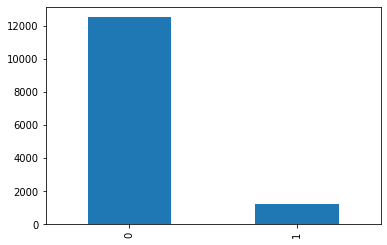

In [ ]:
df['category'].value_counts().plot.bar()

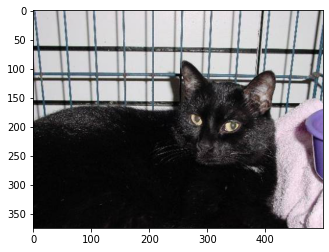

In [ ]:
sample = random.choice(filenames)
image = tf.keras.preprocessing.image.load_img(train_dir + sample)
plt.imshow(image)

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
print(train_df["category"].value_counts())

cat    10011
dog      962
Name: category, dtype: int64


In [ ]:
print(validate_df["category"].value_counts())

cat    2489
dog     255
Name: category, dtype: int64


In [ ]:
# Define generators
train_datagen = tfi.ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest")

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    train_dir,
    color_mode="rgb",
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SHAPE,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 10973 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = tfi.ImageDataGenerator(rescale=1 / 255.0)
valid_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    train_dir, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 2744 validated image filenames belonging to 2 classes.


In [ ]:
class_names = train_generator.class_indices
print("Name classes: {}".format(class_names))

Name classes: {'cat': 0, 'dog': 1}


In [ ]:
imgs, labels = next(train_generator)

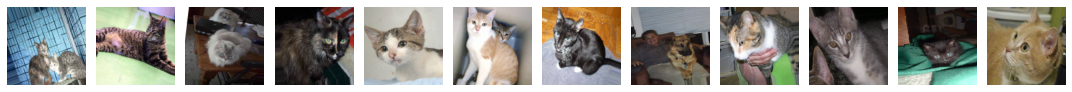

In [ ]:
plotImages(imgs, BATCH_SIZE)

## Define model

In [ ]:
model = tf.keras.Sequential([
            tfl.Conv2D(32, 3, padding='same', activation='relu',input_shape=(128,128,3)),
            tfl.BatchNormalization(),
            tfl.MaxPooling2D(),
            tfl.Dropout(0.25),

            tfl.Conv2D(64, (3,3), padding='same', activation='relu'),
            tfl.BatchNormalization(),
            tfl.MaxPooling2D(),
            tfl.Dropout(0.25),

            tfl.Conv2D(128, (3,3), padding='same', activation='relu'),
            tfl.BatchNormalization(),
            tfl.MaxPooling2D(),
            tfl.Dropout(0.25),

            tfl.Flatten(),
            tfl.Dense(512, activation='relu'),
            tfl.BatchNormalization(),
            tfl.Dropout(0.5),
            tfl.Dense(2, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 65536)             0

## Train model

In [ ]:
history = model.fit_generator(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=EPOCHS)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/5
8/8 [==============================] - 4s 508ms/step - loss: 0.1065 - accuracy: 0.9348 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 2/5
8/8 [==============================] - 4s 490ms/step - loss: 0.2888 - accuracy: 0.8913 - val_loss: 0.0441 - val_accuracy: 1.0000
Epoch 3/5
8/8 [==============================] - 4s 520ms/step - loss: 0.2659 - accuracy: 0.9239 - val_loss: 0.0996 - val_accuracy: 1.0000
Epoch 4/5
8/8 [==============================] - 4s 499ms/step - loss: 0.2103 - accuracy: 0.9130 - val_loss: 0.1002 - val_accuracy: 0.9722
Epoch 5/5
8/8 [==============================] - 4s 479ms/step - loss: 0.1627 - accuracy: 0.9239 - val_loss: 0.0442 - val_accuracy: 1.0000


## Validate model

In [ ]:
model.save_weights("model.h5")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test model

### Prepare test data

In [ ]:
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = tfi.ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test_dir, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 12502 validated image filenames.


### Predict with test

In [ ]:
predict = model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

Test loss: 0.03730136156082153
Test accuracy: 1.0


In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
test_df['category'].value_counts().plot.bar()

### See predicted

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()